### Change dataframe model testing and evaluation

In [184]:
#import libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import ar_select_order
import itertools
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from arch import arch_model
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit


In [129]:
#import data
df = pd.read_csv('../Final Data/df_diff.csv')

df['date'] = pd.to_datetime(df['date'])
df.head()

,date,wheat_price_change,fertilizer_idx_change,avg_temp_change,drought_idx_change,cpi_change,commodity_imp_idx_change,commodity_exp_idx_change,flour_price_change,corn_price_change,crude_oil_price_change
0,1990-02-01,-0.15,5.7,-0.746878,-0.7,0.5,0.2,-0.6,-0.004,0.393654,-0.75
1,1990-03-01,-0.08,-0.5,6.187458,-3.4,0.6,-0.3,0.2,0.003,3.543152,-1.72
2,1990-04-01,0.01,-0.5,5.169554,-3.2,0.3,-0.8,0.3,-0.001,8.661018,-1.96
3,1990-05-01,-0.09,-3.3,4.346403,-0.9,0.2,-0.4,0.2,0.003,2.755760,-0.23
4,1990-06-01,0.45,-3.4,6.257712,0.2,0.8,-0.4,-0.2,0.005,-1.181030,-1.50


In [131]:
#add lagged variables
exog_vars = ['fertilizer_idx_change', 'avg_temp_change', 'drought_idx_change', 
             'cpi_change', 'commodity_imp_idx_change', 'commodity_exp_idx_change',
             'flour_price_change', 'corn_price_change', 'crude_oil_price_change']

for var in exog_vars:
    for lag in range(1, 7):
        df[f'{var}_lag{lag}'] = df[var].shift(lag)

for lag in range(1, 7):
        df[f'wheat_price_change_lag{lag}'] = df['wheat_price_change'].shift(lag)
df = df.dropna()

lagged_features = [col for col in df.columns if 'lag' in col]

scaler = StandardScaler() #standardize
df[lagged_features] = scaler.fit_transform(df[lagged_features])

#change date to month and year vars
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

#drop non-lagged features and date
df = df.drop(columns = ['fertilizer_idx_change', 'avg_temp_change','drought_idx_change','cpi_change',
                        'commodity_imp_idx_change','commodity_exp_idx_change','flour_price_change','corn_price_change',
                       'crude_oil_price_change','date'])

df.head()

,wheat_price_change,fertilizer_idx_change_lag1,fertilizer_idx_change_lag2,fertilizer_idx_change_lag3,fertilizer_idx_change_lag4,fertilizer_idx_change_lag5,fertilizer_idx_change_lag6,avg_temp_change_lag1,avg_temp_change_lag2,avg_temp_change_lag3,...,crude_oil_price_change_lag5,crude_oil_price_change_lag6,wheat_price_change_lag1,wheat_price_change_lag2,wheat_price_change_lag3,wheat_price_change_lag4,wheat_price_change_lag5,wheat_price_change_lag6,year,month
6,-0.21,-0.000654,-0.281667,-0.270624,-0.078621,-0.076427,0.348332,0.367214,1.329930,0.921390,...,-0.375851,-0.180508,-1.700000,0.710463,-0.151261,0.008292,-0.134679,-0.245362,1990,8
7,-0.12,0.081324,-0.001473,-0.277491,-0.270899,-0.076427,-0.077764,-0.143922,0.361496,1.325425,...,-0.424976,-0.379478,-0.341960,-1.700584,0.710948,-0.151377,0.009025,-0.133595,1990,9
8,-0.03,0.388740,0.080535,0.004050,-0.277766,-0.268876,-0.077764,-0.758705,-0.148976,0.357402,...,-0.070873,-0.428708,-0.198168,-0.343372,-1.700042,0.710833,-0.150646,0.010105,1990,10
9,-0.04,0.340920,0.388065,0.086452,0.003785,-0.275749,-0.270195,-1.630643,-0.762960,-0.152853,...,-0.330821,-0.073844,-0.054376,-0.199667,-0.342862,-1.700161,0.711575,-0.149562,1990,11
10,0.01,0.142807,0.340227,0.395460,0.086190,0.006051,-0.277067,-1.292973,-1.633765,-0.766576,...,0.334401,-0.334351,-0.070353,-0.055962,-0.199161,-0.342979,-1.699449,0.712638,1990,12


In [133]:
#split to train/test
y = df['wheat_price_change']
X = df.drop(columns='wheat_price_change')
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]


#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [135]:
results = {}
predictions_df = pd.DataFrame({'Actual': test['wheat_price_change']})

## AR Model

In [138]:
ar_select = ar_select_order(train['wheat_price_change'], maxlag=12)
optimal_lag = ar_select.ar_lags

print(f"Optimal AR lag: {optimal_lag}")
ar_model = AutoReg(train['wheat_price_change'], lags=optimal_lag)
ar_results = ar_model.fit()
print(ar_results.summary())

Optimal AR lag: [1]
                            AutoReg Model Results                             
Dep. Variable:     wheat_price_change   No. Observations:                  331
Model:                     AutoReg(1)   Log Likelihood                -270.378
Method:               Conditional MLE   S.D. of innovations              0.549
Date:                Tue, 06 May 2025   AIC                            546.756
Time:                        14:59:37   BIC                            558.154
Sample:                             1   HQIC                           551.303
                                  331                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0085      0.030      0.280      0.779      -0.051       0.068
wheat_price_change.L1    -0.2440      0.053     -4.570      0.000      -0.349 

In [140]:
#Forecast
ar_preds = ar_results.predict(start=len(train), end=len(train) + len(test) - 1)
ar_mse = mean_squared_error(test['wheat_price_change'], ar_preds)
results['AR'] = ar_mse
predictions_df['AR'] = ar_preds

## ARIMA Model

In [143]:
best_aic = float('inf')
best_order = None

for p in range(3):  # AR order
    for d in range(2):  # Differencing
        for q in range(3):  # MA order
            try:
                model = ARIMA(train['wheat_price_change'], order=(p, d, q))
                model_fit = model.fit()
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_order = (p, d, q)
            except:
                continue

print(f"Best ARIMA order: {best_order}")

# Fit ARIMA with best order
arima_model = ARIMA(train['wheat_price_change'], order=best_order)
arima_fit = arima_model.fit()
print(arima_fit.summary())

Best ARIMA order: (1, 0, 1)
                               SARIMAX Results                                
Dep. Variable:     wheat_price_change   No. Observations:                  331
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -267.300
Date:                Tue, 06 May 2025   AIC                            542.599
Time:                        14:59:40   BIC                            557.808
Sample:                             0   HQIC                           548.665
                                - 331                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0064      0.023      0.276      0.782      -0.039       0.052
ar.L1          0.2683      0.099      2.696      0.007       0.073       0.463
ma.L1         -0.5504   

In [145]:
# Forecast
arima_preds = arima_fit.forecast(steps=len(test))
arima_mse = mean_squared_error(test['wheat_price_change'], arima_preds)
results['ARIMA'] = arima_mse
predictions_df['ARIMA'] = arima_preds

## ARIMAX Model

In [148]:
#save exog variables
exog_lagged_vars = [col for col in X.columns if 'lag' in col and 'wheat_price_change' not in col]
train_exog = train[exog_lagged_vars]
test_exog = test[exog_lagged_vars]

In [150]:
arimax_model = SARIMAX(
    train['wheat_price_change'], 
    exog=train_exog,
    order=best_order,
    seasonal_order=(0, 0, 0, 0)  # No seasonality
)
arimax_fit = arimax_model.fit(disp=False)
print(arimax_fit.summary())

                               SARIMAX Results                                
Dep. Variable:     wheat_price_change   No. Observations:                  331
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -213.608
Date:                Tue, 06 May 2025   AIC                            541.216
Time:                        15:00:14   BIC                            757.936
Sample:                             0   HQIC                           627.653
                                - 331                                         
Covariance Type:                  opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
fertilizer_idx_change_lag1        0.0749      0.085      0.882      0.378      -0.092       0.241
fertilizer_idx_change_lag2        0.1685      0.108      1.560      0.119 

In [154]:
# Forecast
arimax_preds = arimax_fit.forecast(steps=len(test), exog=test_exog)
arimax_mse = mean_squared_error(test['wheat_price_change'], arimax_preds)
results['ARIMAX'] = arimax_mse
predictions_df['ARIMAX'] = arimax_preds

## SARIMAX Model

In [160]:
# Check for seasonality patterns with period=12 (monthly)
for P in range(2):
    for D in range(2):
        for Q in range(2):
            try:
                model = SARIMAX(
                    train['wheat_price_change'], 
                    exog=train_exog,
                    order=best_order,
                    seasonal_order=(P, D, Q, 12)
                )
                model_fit = model.fit(disp=False)
                if model_fit.aic < best_seasonal_aic:
                    best_seasonal_aic = model_fit.aic
                    best_seasonal_order = (P, D, Q, 12)
            except:
                continue

print(f"Best SARIMAX seasonal order: {best_seasonal_order}")

sarimax_model = SARIMAX(
    train['wheat_price_change'], 
    exog=train_exog,
    order=best_order,
    seasonal_order=best_seasonal_order
)
sarimax_fit = sarimax_model.fit(disp=False)
print(sarimax_fit.summary())

NameError: name 'best_seasonal_order' is not defined

In [ ]:
#Forecast
sarimax_preds = sarimax_fit.forecast(steps=len(test), exog=test_exog)
sarimax_mse = mean_squared_error(test['wheat_price_change'], sarimax_preds)
results['SARIMAX'] = sarimax_mse
predictions_df['SARIMAX'] = sarimax_preds

## Basic Decision Tree

In [164]:
#split for 
X_train = train.drop(columns='wheat_price_change')
y_train = train['wheat_price_change']
X_test = test.drop(columns='wheat_price_change')
y_test = test['wheat_price_change']

In [166]:
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [168]:
dt_preds = dt_model.predict(X_test)
dt_mse = mean_squared_error(y_test, dt_preds)
results['Decision Tree'] = dt_mse
predictions_df['Decision Tree'] = dt_preds

## XGBoost Model

In [186]:
tscv = TimeSeriesSplit(n_splits=5)

# Define parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use negative MSE as the scoring metric
    cv=tscv,                           # Time series cross-validation
    verbose=1,
    n_jobs=-1                          # Use all available cores
)

# Perform grid search
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation score: {-grid_search.best_score_}")

best_xgb_model = xgb.XGBRegressor(**grid_search.best_params_, random_state=42)
best_xgb_model.fit(X_train, y_train)

# Evaluate on test set
best_xgb_preds = best_xgb_model.predict(X_test)
best_xgb_mse = mean_squared_error(y_test, best_xgb_preds)
results['XGBoost (Tuned)'] = best_xgb_mse
predictions_df['XGBoost (Tuned)'] = best_xgb_preds

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Best parameters found:
{'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation score: 0.3516245574422145


In [187]:
tuned_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Tuned XGBoost Feature Importance:")
print(tuned_importance.head(10))

Tuned XGBoost Feature Importance:
                          Feature  Importance
26  commodity_imp_idx_change_lag3    0.101756
32  commodity_exp_idx_change_lag3    0.062650
50    crude_oil_price_change_lag3    0.048685
48    crude_oil_price_change_lag1    0.034104
54        wheat_price_change_lag1    0.031037
33  commodity_exp_idx_change_lag4    0.029834
27  commodity_imp_idx_change_lag4    0.026692
41        flour_price_change_lag6    0.023183
0      fertilizer_idx_change_lag1    0.023088
25  commodity_imp_idx_change_lag2    0.021610


In [178]:
results_df = pd.DataFrame({
    'Model': results.keys(),
    'MSE': results.values()
}).sort_values('MSE')

print("\nModel Comparison Results:")
print("-" * 40)
print(results_df)


Model Comparison Results:
----------------------------------------
           Model       MSE
4        XGBoost  0.557521
0             AR  0.665850
1          ARIMA  0.666055
3  Decision Tree  0.690504
2         ARIMAX  1.131915


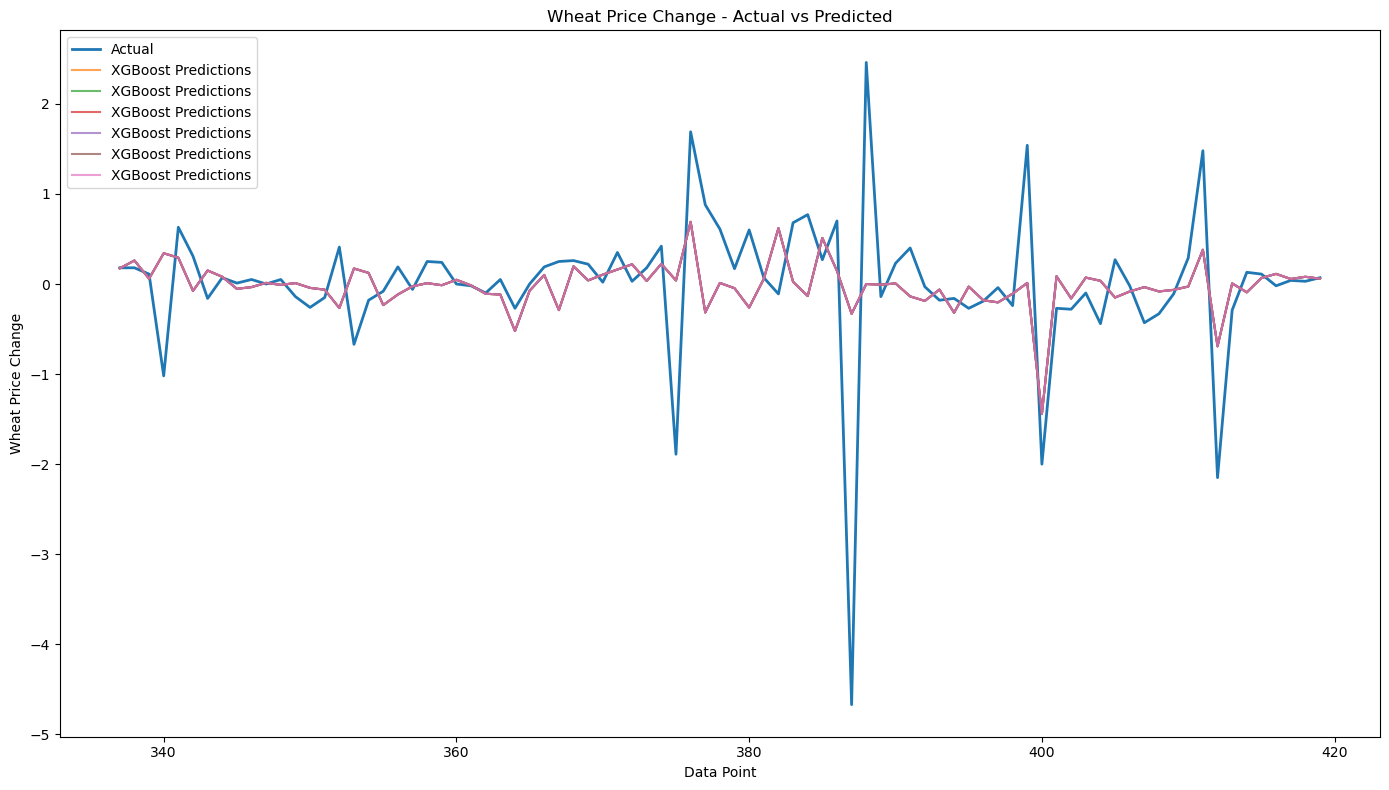

In [190]:
plt.figure(figsize=(14, 8))
plt.plot(predictions_df.index, predictions_df['Actual'], label='Actual', linewidth=2)

for model in results.keys():
    plt.plot(predictions_df.index, predictions_df['XGBoost'], label=f'XGBoost Predictions', alpha=0.7)

plt.legend()
plt.title('Wheat Price Change - Actual vs Predicted')
plt.xlabel('Data Point')
plt.ylabel('Wheat Price Change')
plt.tight_layout()
plt.savefig('predictions_comparison.png')
plt.show()